# IntelliAgent: Multi-Agent System with SAP AI Core

## Overview
This notebook implements a multi-agent system that uses SAP AI Core for intelligent task execution. The system consists of:

1. Worker Agent (using gpt-4.1)
   - Handles complex task execution
   - Uses web browsing tools
   - Maintains conversation context

2. Evaluator Agent (using mistral-small-instruct)
   - Validates responses
   - Provides structured feedback
   - Makes decisions on task completion

## Steps in this Notebook:
1. Setup and Dependencies
2. Schema Definition
3. Tool Configuration
4. SAP AI Core Integration
5. Model Configuration
6. Agent Implementation
7. Graph Construction
8. User Interface

## Prerequisites
- SAP AI Core credentials in .env file
- Python environment with required packages
- Network access to SAP AI Core endpoints


# Step 1: Setup and Dependencies
Install required packages and import necessary libraries.

In [34]:
%pip install "langgraph[all]" langchain-community langchain-openai langsmith --quiet

from typing import Annotated, TypedDict, List, Dict, Any, Optional
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langsmith import Client
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.tracers import LangChainTracer
import langsmith
from pydantic import BaseModel, Field
from IPython.display import Image, display
import gradio as gr
import uuid
import json
import os

# Add SQLite memory configuration
import sqlite3
# from langgraph.checkpoint.sqlite import SqliteSaver

# Initialize SQLite connection for persistent memory
db_path = "intelliagent_memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
# sql_memory = SqliteSaver(conn)

from dotenv import load_dotenv
load_dotenv(override=True)

# Configure LangSmith
langsmith_tracing = os.environ["LANGCHAIN_TRACING_V2"]
langsmith_proj_name=os.getenv("LANGSMITH_PROJECT")

# Initialize LangSmith client
langsmith_client = Client()



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Step 2: Schema Definition
Define the data structures for our agents' communication and state management.

In [35]:
# Define Evaluator Output structure
class EvaluatorOutput(BaseModel):
    feedback: str = Field(description="Feedback on the assistant's response")
    success_criteria_met: bool = Field(description="Whether the success criteria have been met")
    user_input_needed: bool = Field(description="True if more input is needed from the user")

# Define State management
class State(TypedDict):
    messages: Annotated[List[Any], add_messages]
    success_criteria: str
    feedback_on_work: Optional[str]
    success_criteria_met: bool
    user_input_needed: bool


# Step 3: Tool Configuration
Set up web browsing capabilities using Playwright.

In [36]:
# Configure Playwright tools
import nest_asyncio
nest_asyncio.apply()
async_browser = create_async_playwright_browser(headless=False)  # headful mode
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()


# Step 4: SAP AI Core Integration
Initialize and test connection to SAP AI Core services.

In [37]:
import sys
import os

sys.path.append('..')
from llm_client import CL_Foundation_Service, CL_Orchestration_Service

# Configure SAP AI Core
aic_config = {
    "aic_client_id": os.getenv('AIC_CLIENT_ID'),
    "aic_client_secret": os.getenv('AIC_CLIENT_SECRET'),
    "aic_resource_group": os.getenv('AIC_RESOURCE_GROUP'),
    "aic_base_url": os.getenv('AIC_BASE_URL'),
    "aic_auth_url": os.getenv('AIC_AUTH_URL'),
    "default_model": os.getenv('AIC_FOUNDATIN_MODEL', 'gpt-4'),
    "default_temperature": 0.7
}

# Initialize Foundation Service
foundation_service = CL_Foundation_Service(aic_config)

# Test foundation service
try:
    response = foundation_service.invoke_llm(
        prompt="What is the model you are using",
        temperature=0.1
    )
    print("SAP AiCore Response:")
    print(response)
except Exception as e:
    print(f"Error calling SAP AiCore: {e}")
    print("Please check your credentials and network connection")

# Initialize orchestration service
orch_params = {
    "orch_url": os.getenv('AIC_ORCH_URL'),
    "orch_model": os.getenv('AIC_ORCH_MODEL'),
    "parameters": {
        "temperature": 0.7,
        "max_tokens": 1000,
        "top_p": 0.9
    }
}

orch_service = CL_Orchestration_Service(aic_config, orch_params)

# Test orchestration service
try:
    orch_response = orch_service.invoke_llm(
        prompt="What is the model you are using?",
        temperature=0.3
    )
    print("Orchestration Service Response:")
    print(orch_response)
except Exception as e:
    print(f"Orchestration service error: {e}")
    print("Make sure AIC_ORCH_URL and AIC_ORCH_MODEL are set in your .env file")


SAP AiCore Response:
I am based on OpenAI's GPT-4 architecture. My responses are generated using the GPT-4 language model, which is designed to understand and generate human-like text based on the input I receive. If you have any specific questions about my capabilities or how I work, feel free to ask!
Orchestration Service Response:
I'm Claude, an AI assistant created by Anthropic. I'm built on Anthropic's constitutional AI technology, but I don't have detailed information about my specific model architecture, parameters, or version number. Anthropic hasn't shared those technical specifics with me.

Is there something particular about my capabilities or how I work that you'd like to know more about? I'm happy to discuss what I can help with or answer questions about my functionality.
Orchestration Service Response:
I'm Claude, an AI assistant created by Anthropic. I'm built on Anthropic's constitutional AI technology, but I don't have detailed information about my specific model archi

# Step 5: Model Configuration
Configure the worker and evaluator models.

In [38]:
# Initialize LLM clients with LangSmith tracing
# Create a tracer for each model to track its interactions
worker_tracer = LangChainTracer(
    project_name=langsmith_proj_name,
    tags=["worker"]
)
evaluator_tracer = LangChainTracer(
    project_name=langsmith_proj_name,
    tags=["evaluator"]
)

# Set up callback handlers for each agent
worker_callbacks = CallbackManager.configure(
    inheritable_callbacks=[worker_tracer],
    local_callbacks=None,
    verbose=True
)

evaluator_callbacks = CallbackManager.configure(
    inheritable_callbacks=[evaluator_tracer],
    local_callbacks=None,
    verbose=True
)

# Worker agent uses gpt-4.1 which is ideal for:
# - Complex reasoning with tools
# - Multi-step task planning 
# - Understanding context and tool capabilities
worker_llm = foundation_service.get_llm_client(
    model_name='gpt-4.1',
    callback_manager=worker_callbacks
)
llm_with_tools = worker_llm.bind_tools(tools)

# Evaluator agent uses mistral-small-instruct which excels at:
# - Structured output generation
# - Consistent format validation 
# - Quick feedback evaluation
evaluator_llm = foundation_service.get_llm_client(
    model_name='gpt-4.1',
    callback_manager=evaluator_callbacks
)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Step 6: Agent Implementation
Define the worker and evaluator agents.

In [39]:
# Worker agent implementation
def worker(state: State) -> Dict[str, Any]:
    system_message = f"""You are a helpful assistant that can use tools to complete tasks.
You keep working on a task until either you have a question or clarification for the user, or the success criteria is met.
This is the success criteria:
{state['success_criteria']}
You should reply either with a question for the user about this assignment, or with your final response.
If you have a question for the user, you need to reply by clearly stating your question. An example might be:

Question: please clarify whether you want a summary or a detailed answer

If you've finished, reply with the final answer, and don't ask a question; simply reply with the answer.
"""
    
    if state.get("feedback_on_work"):
        system_message += f"""
Previously you thought you completed the assignment, but your reply was rejected because the success criteria was not met.
Here is the feedback on why this was rejected:
{state['feedback_on_work']}
With this feedback, please continue the assignment, ensuring that you meet the success criteria or have a question for the user."""
    
    # Add in the system message

    found_system_message = False
    messages = state["messages"]
    for message in messages:
        if isinstance(message, SystemMessage):
            message.content = system_message
            found_system_message = True
    
    if not found_system_message:
        messages = [SystemMessage(content=system_message)] + messages
    
    # Invoke the LLM with tools
    response = llm_with_tools.invoke(messages)
    
    # Return updated state
    return {
        "messages": [response],
    }

# Worker router implementation
def worker_router(state: State) -> str:
    last_message = state["messages"][-1]
    
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    else:
        return "evaluator"

# Conversation formatting helper
def format_conversation(messages: List[Any]) -> str:
    conversation = "Conversation history:\n\n"
    for message in messages:
        if isinstance(message, HumanMessage):
            conversation += f"User: {message.content}\n"
        elif isinstance(message, AIMessage):
            text = message.content or "[Tools use]"
            conversation += f"Assistant: {text}\n"
    return conversation

# Evaluator implementation
def evaluator(state: State) -> State:
    last_response = state["messages"][-1].content

    system_message = """You are an evaluator that determines if a task has been completed successfully by an Assistant.
Assess the Assistant's last response based on the given criteria. Respond with your feedback, and with your decision on whether the success criteria has been met,
and whether more input is needed from the user.

Please respond with a JSON object in this exact format:
{
    "feedback": "Your feedback here",
    "success_criteria_met": true/false,
    "user_input_needed": true/false
}"""
    
    user_message = f"""You are evaluating a conversation between the User and Assistant. You decide what action to take based on the last response from the Assistant.

The entire conversation with the assistant, with the user's original request and all replies, is:
{format_conversation(state['messages'])}

The success criteria for this assignment is:
{state['success_criteria']}

And the final response from the Assistant that you are evaluating is:
{last_response}

Respond with your feedback, and decide if the success criteria is met by this response.
Also, decide if more user input is required, either because the assistant has a question, needs clarification, or seems to be stuck and unable to answer without help.
"""
    
    if state.get("feedback_on_work"):
        user_message += f"Also, note that in a prior attempt from the Assistant, you provided this feedback: {state['feedback_on_work']}\n"
        user_message += "If you're seeing the Assistant repeating the same mistakes, then consider responding that user input is required."
    
    evaluator_messages = [SystemMessage(content=system_message), HumanMessage(content=user_message)]
    
    # Use regular LLM instead of structured output (SAP AI Core compatible)
    response = evaluator_llm.invoke(evaluator_messages)

    # Parse JSON response manually
    try:
        # Try to extract JSON from the response
        response_text = response.content
        
        # Find JSON in the response (it might be wrapped in markdown or other text)
        start_idx = response_text.find('{')
        end_idx = response_text.rfind('}') + 1
        
        if start_idx != -1 and end_idx != -1:
            json_str = response_text[start_idx:end_idx]
            eval_result = json.loads(json_str)
        else:
            # Fallback if no JSON found
            raise json.JSONDecodeError("No JSON found", response_text, 0)
            
        feedback = eval_result.get("feedback", "No feedback provided")
        success_criteria_met = eval_result.get("success_criteria_met", False)
        user_input_needed = eval_result.get("user_input_needed", False)
        
    except (json.JSONDecodeError, KeyError, TypeError) as e:
        # Fallback if JSON parsing fails
        print(f"JSON parsing failed: {e}")
        print(f"Response was: {response.content}")
        feedback = response.content
        success_criteria_met = False
        user_input_needed = True
    
    new_state = {
        "messages": [{"role": "assistant", "content": f"Evaluator Feedback on this answer: {feedback}"}],
        "feedback_on_work": feedback,
        "success_criteria_met": success_criteria_met,
        "user_input_needed": user_input_needed
    }
    return new_state

def route_based_on_evaluation(state: State) -> str:
    if state["success_criteria_met"] or state["user_input_needed"]:
        return "END"
    else:
        return "worker"


# Step 7: Graph Construction
Build the multi-agent workflow graph.

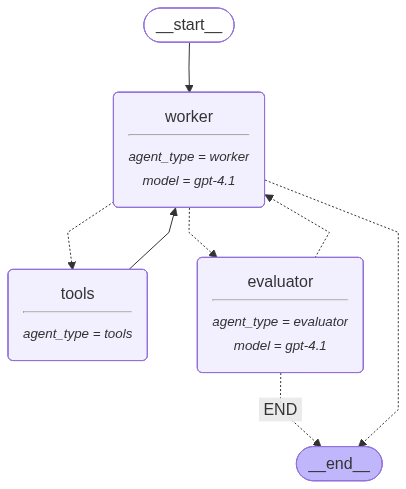

In [40]:
# Set up Graph Builder with State and LangSmith tracing
graph_builder = StateGraph(State)

# Add nodes with tracing metadata
graph_builder.add_node("worker", worker, metadata={"agent_type": "worker", "model": "gpt-4.1"})
graph_builder.add_node("tools", ToolNode(tools=tools), metadata={"agent_type": "tools"})
graph_builder.add_node("evaluator", evaluator, metadata={"agent_type": "evaluator", "model": "gpt-4.1"})

# Add edges (metadata not supported in current version)
graph_builder.add_conditional_edges(
    "worker", 
    worker_router, 
    {"tools": "tools", "evaluator": "evaluator"}
)
graph_builder.add_edge("tools", "worker")
graph_builder.add_conditional_edges(
    "evaluator", 
    route_based_on_evaluation, 
    {"worker": "worker", "END": END}
)
graph_builder.add_edge(START, "worker")

# Create the graph with SQL persistence and tracing
graph = graph_builder.compile()

# Example usage with complete initial state and run metadata
initial_state = {
    "messages": [{"role": "user", "content": "Hello! I'm ready to help with the project."}],
    "success_criteria": "Provide a helpful and informative response to the user's greeting",
    "feedback_on_work": None,
    "success_criteria_met": False,
    "user_input_needed": False
}

# Add tracing metadata at the run level instead
run_metadata = {
    "project": langsmith_proj_name,
    "run_type": "example",
    "graph_structure": {
        "edges": {
            "tools_to_worker": "Direct connection from tools to worker",
            "start_to_worker": "Initial worker call",
            "worker_routing": "Routes based on tool usage",
            "evaluator_routing": "Routes based on evaluation results"
        }
    }
}

next_state = await graph.ainvoke(initial_state, config={"metadata": run_metadata})

# Display graph visualization
display(Image(graph.get_graph().draw_mermaid_png()))


# Step 8: User Interface
Create the Gradio interface for user interaction.

In [59]:
# UI callback implementation
def make_thread_id() -> str:
    return str(uuid.uuid4())

# Message processing with LangSmith tracking
async def process_message(message, success_criteria, history, thread):
    # Create LangSmith run metadata
    run_metadata = {
        "thread_id": thread,
        "success_criteria": success_criteria,
        "interface": "gradio"
    }
    
    config = {
        "configurable": {"thread_id": thread},
        "metadata": run_metadata,
        "callbacks": [
            LangChainTracer(
                project_name=langsmith_proj_name,
                tags=["chat_interface"]
            )
        ]
    }

    state = {
        "messages": message,
        "success_criteria": success_criteria,
        "feedback_on_work": None,
        "success_criteria_met": False,
        "user_input_needed": False
    }
    
    # Execute with tracing configured in the config
    result = await graph.ainvoke(state, config=config)
    
    user = {"role": "user", "content": message}
    reply = {"role": "assistant", "content": result["messages"][-2].content}
    feedback = {"role": "assistant", "content": result["messages"][-1].content}
    return history + [user, reply, feedback]

async def reset():
    return "", "", None, make_thread_id()

# UI construction
with gr.Blocks(theme=gr.themes.Default(primary_hue="emerald")) as demo:
    gr.Markdown("## IntelliAgent Professional Assistant (SAP AI Core Compatible)")
    thread = gr.State(make_thread_id())
    
    with gr.Row():
        chatbot = gr.Chatbot(label="IntelliAgent", height=600, type="messages")
    with gr.Group():
        with gr.Row():
            message = gr.Textbox(show_label=False, placeholder="Your request to your IntelliAgent")
        with gr.Row():
            success_criteria = gr.Textbox(show_label=False, placeholder="What are your success criteria?")
    with gr.Row():
        reset_button = gr.Button("Reset", variant="stop")
        go_button = gr.Button("Go!", variant="primary")
    message.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    success_criteria.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    go_button.click(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    reset_button.click(reset, [], [message, success_criteria, chatbot, thread])

    
demo.launch()


* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.


### Test Cases to Validate the Functionality - Integrated with Langsmith

In [53]:
# Test Case 1: Basic Human Interaction
print("Test Case 1: Self Awareness")
initial_state = {
    "messages": [{"role": "user", "content": "Can you explain your architecture"}],
    "success_criteria": "Provide a clear and comprehensive overview of your capabilities",
    "feedback_on_work": None,
    "success_criteria_met": False,
    "user_input_needed": False
}

# Configure test-specific tracing
test1_config = {
    "metadata": {
        "test_case": "self_awareness",
        "test_type": "basic_interaction"
    },
    "callbacks": [
        LangChainTracer(
            project_name=langsmith_proj_name,
            tags=["test_case", "self_awareness"]
        )
    ]
}

response1 = await graph.ainvoke(initial_state, config=test1_config)
print("\nResponse:", response1["messages"][-2].content)
print("Feedback:", response1["messages"][-1].content)


Test Case 1: Self Awareness

Response: Certainly! Here’s an overview of my architecture and how I work:

1. Foundation: Large Language Model (LLM)
I am built on advanced large language models—primarily variants of OpenAI’s GPT-4. This means I have been trained on vast amounts of text data to understand natural language, generate human-like responses, and perform a wide variety of tasks such as answering questions, summarizing content, and generating text.

2. Modular Tool Integration
In addition to core language capabilities, I can integrate with external tools and plugins. These tools allow me to interact with web pages, perform searches, extract data, click elements, and more. This modular structure enables me to perform complex tasks that go beyond text generation, such as web automation and data extraction.

3. Workflow Management
I operate with a goal-oriented workflow. When given a task, I break it down into steps and choose the appropriate actions (e.g., asking clarifying questi

In [54]:
# Test Case 2: Web Research Task
print("\nTest Case 2: Web Research Using Tools")
research_state = {
    "messages": [{
        "role": "user", 
        "content": "How is the sentiment for the Tesla Car Launch in India"
    }],
    "success_criteria": "Use web browsing tools to find and summarize recent information",
    "feedback_on_work": None,
    "success_criteria_met": False,
    "user_input_needed": False
}

# Configure test-specific tracing
test2_config = {
    "metadata": {
        "test_case": "web_research",
        "test_type": "tool_usage"
    },
    "callbacks": [
        LangChainTracer(
            project_name=langsmith_proj_name,
            tags=["test_case", "web_research"]
        )
    ]
}

response2 = await graph.ainvoke(research_state, config=test2_config)
print("\nResponse:", response2["messages"][-2].content)
print("Feedback:", response2["messages"][-1].content)



Test Case 2: Web Research Using Tools

Response: Final answer:

There is strong anticipation and positive sentiment surrounding the Tesla car launch in India. Recent news reports indicate that Tesla is preparing for its official entry into the Indian market in 2024, with plans for a local manufacturing facility likely by 2026. The sentiment among both industry observers and potential customers is generally optimistic, driven by expectations that Tesla's arrival will boost the electric vehicle ecosystem in India, increase competition, and accelerate EV adoption.

However, there are also cautious views regarding regulatory challenges, pricing, infrastructure readiness, and long-standing delays in Tesla's entry. Some reports highlight the Indian government's efforts to incentivize EV manufacturing and the importance of affordable pricing for mass adoption. Overall, the sentiment is a mix of excitement, hope, and pragmatic concerns, reflecting the high profile and transformative potential

In [ ]:
# Test Case 3: Feedback Loop Testing
print("\nTest Case 3: Handling Feedback and Improvement")
feedback_state = {
    "messages": [{
        "role": "user", 
        "content": "Write a short paragraph about Quantum Computing"
    }],
    "success_criteria": "Create a paragraph that includes technical concepts but remains accessible",
    "feedback_on_work": "The paragraph needs more technical concepts while maintaining its artistic value",
    "success_criteria_met": False,
    "user_input_needed": False
}

# Configure test-specific tracing
test3_config = {
    "metadata": {
        "test_case": "feedback_loop",
        "test_type": "iterative_improvement"
    },
    "callbacks": [
        LangChainTracer(
            project_name=langsmith_proj_name,
            tags=["test_case", "feedback_loop"]
        )
    ]
}

response3 = await graph.ainvoke(feedback_state, config=test3_config)
print("\nResponse:", response3["messages"][-2].content)
print("Feedback:", response3["messages"][-1].content)



Test Case 3: Handling Feedback and Improvement

Response: Quantum computing harnesses the principles of quantum mechanics, such as superposition and entanglement, to perform computations far beyond the capabilities of classical computers. Unlike traditional bits, which are limited to values of 0 or 1, quantum bits (qubits) can exist in multiple states simultaneously, allowing quantum computers to process complex information more efficiently. Quantum algorithms, like Shor’s algorithm for factoring large numbers and Grover’s algorithm for searching unsorted databases, demonstrate potential breakthroughs in cryptography and optimization. While quantum hardware faces challenges like decoherence and error correction, ongoing advancements promise transformative impacts across fields including materials science, pharmaceuticals, and artificial intelligence.

Response: Quantum computing harnesses the principles of quantum mechanics, such as superposition and entanglement, to perform computati

In [57]:
# Test Case 4: Complex Task with Multiple Steps
print("\nTest Case 4: Multi-step Task Execution")
complex_state = {
    "messages": [{
        "role": "user", 
        "content": "Research the differences between MacOS and Windows, create a comparison table, and recommend which one to use for a Developer"
    }],
    "success_criteria": """
    1. Use tools to gather accurate information
    2. Create a clear comparison table
    3. Provide a well-reasoned recommendation
    4. Consider enterprise-specific factors
    """,
    "feedback_on_work": "The comparison table needs more detailed information, and the recommendation should address AI Engineer Needs.",
    "success_criteria_met": False,
    "user_input_needed": False
}

# Configure test-specific tracing
test4_config = {
    "metadata": {
        "test_case": "complex_task",
        "test_type": "multi_step"
    },
    "callbacks": [
        LangChainTracer(
            project_name=langsmith_proj_name,
            tags=["test_case", "complex_task", "tool_usage"]
        )
    ]
}

response4 = await graph.ainvoke(complex_state, config=test4_config)
print("\nResponse:", response4["messages"][-2].content)
print("Feedback:", response4["messages"][-1].content)



Test Case 4: Multi-step Task Execution

Response: Here is a detailed comparison table between macOS and Windows, with a focus on factors relevant to enterprise AI engineers and developers:

| Feature/Aspect         | macOS                                           | Windows                                       |
|-----------------------|-------------------------------------------------|-----------------------------------------------|
| Hardware Integration  | Tight integration with Apple hardware; stable, optimized performance | Wide range of hardware options; variable quality/performance |
| Software Ecosystem    | UNIX-based; comes with Terminal, bash/zsh, native support for many developer tools | Powerful, but not UNIX-based; WSL provides Linux compatibility, but extra setup required |
| Development Tools     | Native support for Xcode (iOS/macOS dev), Homebrew, Docker, Python, Ruby, Node.js; easy access to open-source tools | Visual Studio (Windows dev), PowerShell, WSL2, Docker,